In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

# Func

In [119]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        meta = meta.head(1) # multisession, only keep one metadata
    return meta

In [173]:
def df_adp_mag(adp_mag, dfof_ad, dfof_tg):
    mag = adp_mag.flatten('F')
    ad = dfof_ad.flatten('F')
    tg = dfof_tg.flatten('F')

    cell_num = [np.arange(adp_mag.shape[0])] * adp_mag.shape[1]
    cell_num = np.concatenate(cell_num)
    stim = [np.arange(nstim)] * adp_mag.shape[0]
    stim_flat = np.sort([item for sublist in stim for item in sublist])
    
    df = pd.DataFrame({'cell':cell_num ,'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
    return stim_flat, mag, ad, df


def threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=10): 
    '''no threshold for dfof_ad bc too few shared stim for side A/B'''
    df_th = df.copy()
    # df_th.loc[df_th[(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan # not threshold by abs, bc 1-tail ttest originally
    df_th.loc[df_th[np.abs(df.mag) > adp_threshold].index.to_numpy(),'mag'] = np.nan # bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag
    
    mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
    mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
    mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
    mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
    return df_th, mag_mean, mag_median, mag_std, mag_sem

# Load

In [174]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
print(meta)

dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'resp_base_trialwise' + '.mat'))
# dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] - dfof_trialwise['dfof_base_trial'] # subtract baseline???
dfof_tg_trial = dfof_trialwise['dfof_tg_trial'] - dfof_trialwise['dfof_base2_trial']


   mouse           date area  num
0   1350  211222_caiman   V1  2.0


# split side A/B bootstrap

In [277]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]

dfof_ad_sideA = np.empty((ncell, nstim))
dfof_ad_sideB = np.empty((ncell, nstim))
dfof_tg_sideA = np.empty((ncell, nstim))
dfof_tg_sideB = np.empty((ncell, nstim))

niter = 10
corr_pearson_iter = np.zeros((1, ncell))
p_pearson_iter = np.zeros((1, ncell))
corr_spearman_iter = np.zeros((1, ncell))
nstim_shared_iter = np.zeros((1, ncell))

for i in tqdm(np.arange(niter)):
    for icell in np.arange(ncell):
        for istim in np.arange(nstim):
            ntrial_cond = dfof_ad_trial[icell,istim].shape[0]

            idx_trial = np.random.choice(np.arange(ntrial_cond), size=ntrial_cond//2, replace=False)
            dfof_ad_sideA[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial,:])
            dfof_tg_sideA[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial,:])

            idx_trial_diff = np.setdiff1d(np.arange(ntrial_cond), idx_trial)
            dfof_ad_sideB[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial_diff,:])
            dfof_tg_sideB[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial_diff,:])

    # adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_sideA + 1e-7)
    # adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_sideB + 1e-7)
    adp_sideA = dfof_ad_sideA
    adp_sideB = dfof_ad_sideB
    _, _, _, df_sideA = df_adp_mag(adp_sideA, dfof_ad_sideA, dfof_tg_sideA)
    _, _, _, df_sideB = df_adp_mag(adp_sideB, dfof_ad_sideB, dfof_tg_sideB)

    corr_pearson_pop = []
    p_pearson_pop = []
    corr_spearman_pop = []
    nstim_shared = []

    for icell in np.arange(ncell):
        df_sideA_cell = df_sideA.loc[df_sideA['cell'] == icell]
        df_sideB_cell = df_sideB.loc[df_sideB['cell'] == icell]
        _, mag_mean_sideA_cell, _, _, _ = threshold_adp_mag(df_sideA_cell, dfof_threshold=0.00025, adp_threshold=10)
        _, mag_mean_sideB_cell, _, _, _ = threshold_adp_mag(df_sideB_cell, dfof_threshold=0.00025, adp_threshold=10)

        not_nan_mask = (~np.isnan(mag_mean_sideA_cell)) & (~np.isnan(mag_mean_sideB_cell))
        nstim_shared.append(sum(not_nan_mask))

        corr_pearson_cell, p_pearson_cell = stats.pearsonr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask])
        corr_spearman_cell, _ = stats.spearmanr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask]) # spearman p is only probably reasonable for datasets larger than 500

        corr_pearson_pop.append(corr_pearson_cell)
        p_pearson_pop.append(p_pearson_cell)
        corr_spearman_pop.append(corr_spearman_cell)
        
    nstim_shared_iter = np.vstack((nstim_shared_iter, nstim_shared))
    corr_pearson_iter = np.vstack((corr_pearson_iter, corr_pearson_pop))
    p_pearson_iter = np.vstack((p_pearson_iter, p_pearson_pop))
    corr_spearman_iter = np.vstack((corr_spearman_iter, corr_spearman_pop))

nstim_shared_iter = nstim_shared_iter[1:,:] # remove the first row of zeros
corr_pearson_iter = corr_pearson_iter[1:,:]
p_pearson_iter = p_pearson_iter[1:,:]
corr_spearman_iter = corr_spearman_iter[1:,:]

100%|██████████| 10/10 [00:52<00:00,  5.20s/it]


0.0

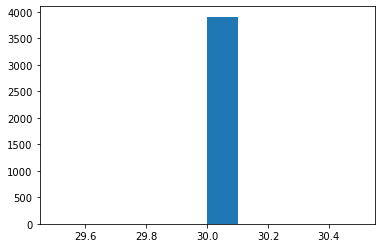

In [278]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

Text(0, 0.5, 'Pearson correlation')

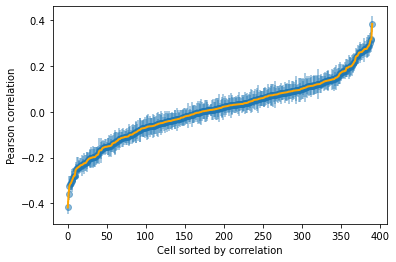

In [279]:
corr_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_avg_sort_id = np.argsort(corr_avg)
corr_avg_sort = corr_avg[corr_avg_sort_id]
corr_sem = np.nanstd(corr_pearson_iter, axis=0) / np.sqrt(corr_pearson_iter.shape[0])
corr_sem_sort = corr_sem[corr_avg_sort_id]
plt.errorbar(np.arange(ncell), corr_avg_sort, yerr=corr_sem_sort, fmt='o', alpha=0.5)
plt.plot(np.arange(ncell), corr_avg_sort, color='orange', zorder=10, linewidth=2)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson correlation')

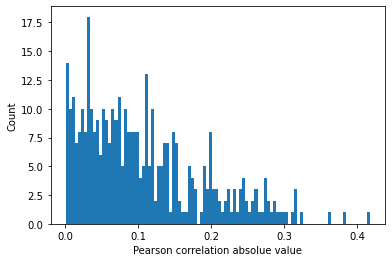

In [280]:
corr_abs = np.abs(corr_avg)
plt.hist(corr_abs, 100);
plt.xlabel('Pearson correlation absolue value')
plt.ylabel('Count');

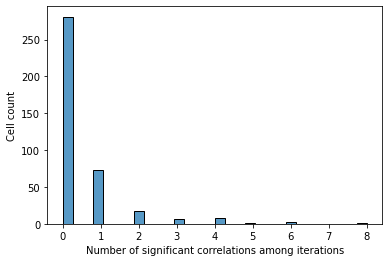

In [281]:
# plt.imshow(p_pearson_iter[:,:5], cmap='viridis', aspect='auto')
# plt.colorbar()
# p_pearson_iter.shape

sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel('Number of significant correlations among iterations')
plt.ylabel('Cell count');

# plt.figure(figsize=(10,15))
# plt.imshow(p_pearson_iter.T < 0.05); plt.colorbar()


In [286]:
sum(sig>3)

12

0.04782608695652174

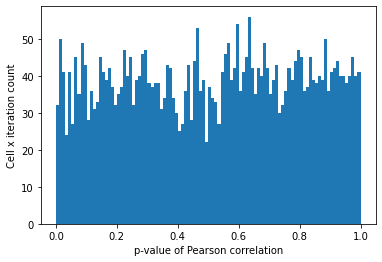

In [282]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())